In [32]:
from models import multi_unet_model, attention_unet, residual_unet
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from patchify import patchify
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import normalize
from sklearn.model_selection import KFold 
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
from scipy.ndimage import rotate
# from evaluate import *

# from dataset import *

path2weights = "../results/models/EPOCHS100_ATTENTION_categorical_crossentropy_esFalse_augFalse/attention.hdf5"

In [33]:
# def get_filepaths(IMG_PATH="../datasets/FIB Tomography/images", MASK_PATH="../datasets/FIB Tomography/images"):
def get_filepaths(IMG_PATH="../datasets/100nm/Images/Aligned SEM Images"):
    impaths = [] # to store paths of images from folder
    for im in os.listdir(IMG_PATH):  # read image name from folder and append its path into "images" array     
        impaths.append(os.path.join(IMG_PATH,im))
    impaths.sort()
    print(f"{len(impaths)} Filepaths received")
    return impaths[:3]

def get_original_images(images):
    dim = (1280,640)
    # load original images
    images = [im for im in images if ".tif" in im]
    original_images = []
    for i in tqdm(range(len(images[:3]))):
        # load images and extract file paths
        original_images.append(cv2.resize(cv2.imread(images[i],0), dim, interpolation=cv2.INTER_NEAREST))
    print(f"Original Images: {len(original_images)}") # ensure images loaded correctly
    plt.imshow(original_images[0],cmap="gray");plt.axis(False)
    return original_images

def get_augmented_images(original_images):
    images_to_generate=1000 # double
    seed_for_random = 42
    i=0   # variable to iterate till images_to_generate
    aug_images, aug_masks = [],[]
    while i<=images_to_generate: 
        number = random.randint(0, len(original_images)-1)  #PIck a number to select an image & mask
        image = original_images[number]

        transformed_image = None # initialized transformed images

        n = 0       #variable to iterate till number of transformation to apply
        transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image

        while n <= transformation_count:
            key = random.choice(list(transformations)) #randomly choosing method to call
            seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
            transformed_image = transformations[key](image, seed)
            n = n + 1
        if(2 in np.unique(transformed_mask) or 5 in np.unique(transformed_mask)):
            aug_images.append(transformed_image)
        i =i+1
    return aug_images

def patchify_dataset(original_images, augment=False):
    patches = []
    for i in range(len(original_images)):
        p = (128,256)# desired patch size
        image_patches = patchify(original_images[i],(p[0],p[1]), step=p[0])
        tmp = []
        for x in range(len(image_patches)):
            for y in range(len(image_patches[0])):
                tmp.append(image_patches[x,y,:,:]);
        patches.append(tmp)
        print(np.array(tmp).shape)
    if augment:
        print("Augmentation Enabled")
        aug_images,aug_masks = get_augmented_images(X_train,y_train) # augment training images
        X_train,y_train = np.array(X_train+aug_images), np.array(y_train+aug_masks)
    else:
        print("Augmentation Disabled")
        patches = np.array(patches)
    print("Total: ", len(patches))
    print(patches.shape)
    return patches

In [34]:
def get_trainvaltest_split(original_images):
    test_images = np.expand_dims(original_images, axis=4)
    test_images = normalize(test_images, axis=1) # Normalize datasets
    print(test_images.shape)
    return test_images

def create_dataset(number, augment=False):
    impaths = get_filepaths(IMG_PATH="../datasets/100nm/Images/Aligned SEM Images") # get paths to all files
    original_images = get_original_images(impaths) # get all original images
    
    patches = patchify_dataset(original_images, augment) # patchify
    return get_trainvaltest_split(patches)

150 Filepaths received


100%|██████████| 3/3 [00:00<00:00, 291.36it/s]

Original Images: 3
(45, 128, 256)
(45, 128, 256)
(45, 128, 256)
Augmentation Disabled
Total:  3
(3, 45, 128, 256)
(3, 45, 128, 256, 1)
test_images shape: (3, 45, 128, 256, 1)


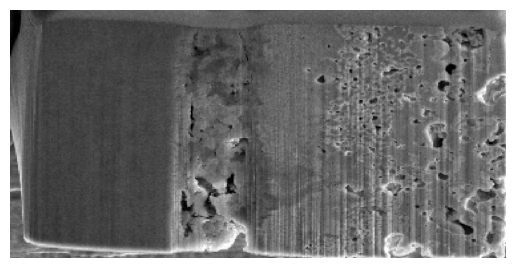

In [38]:
n_classes = 6
# def get_model():
#     return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
def get_model():
    return attention_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
test_images = create_dataset(0, augment=False)
print(f"test_images shape: {test_images.shape}")
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS = test_images.shape[2],test_images.shape[3],test_images.shape[4]
# start training
scores, iou_list, acc_list = {},[],[]
# initialize model
model = get_model()
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy']) 

In [39]:
def unpatch(patches):
    final_image = np.zeros((256,256))
    current_x = 0 # keep track of where your current image was last placed in the y coordinate
    images = [patches[0,:,:64,0],patches[1,:,:,0]]
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
        current_x += image.shape[1]
    new_image = final_image[:128,:64+128]
    
    final_image = np.zeros((256,256))
    current_x = 0 # keep track of where your current image was last placed in the y coordinate
    images = [new_image[:,:128],patches[2,:,:,0]]
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
        current_x += image.shape[1]
    return final_image[:128,:]

def combine_patches(top,bot):
    images = [top,bot]
    final_image = np.zeros((256,256))
    current_y = 0 # keep track of where your current image was last placed in the y coordinate
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[current_y:image.shape[0]+current_y,:image.shape[1]] = image
        current_y += image.shape[0]
    return final_image

# def unpatchify(patches):
#     top = unpatch(patches[0:4])
#     bot = unpatch(patches[6:9])
#     return combine_patches(top,bot)

def unpatchify(patches):
    image_patches = np.zeros((5, 9, 128, 256))
    i,j = 0,0
    for idx in range(len(patches)):
        image_patches[i,j,:,:] = patches[idx,:,:,0]
        j+=1
        if j == 9:
            j=0
            i+=1
            
    p = (128,256)
    tmp = np.zeros((640,1280))
    for i in range(len(image_patches)):
        count = 0
        for j in range(len(image_patches[0])):
            if(j%2 == 0):
                tmp[p[0]*i:p[0]*(i+1), p[1]*count:p[1]*(count+1)] = image_patches[i,j,:,:]
                count += 1
    return tmp

In [40]:
model.load_weights(path2weights)

X_test = test_images[1]
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3) # combine prediction to single image
pred = np.expand_dims(y_pred_argmax,axis=3)
if(X_test.shape[1] < 256):
    img,msk = unpatchify(X_test), unpatchify(pred) # unpatchify target and prediction
    #target, predicted = to_categorical(gt, num_classes=n_classes), to_categorical(msk, num_classes=n_classes) # split classes
else:
    img,msk = X_test[0,:,:,0],pred[0,:,:,0] 
#     target, predicted = y_test, pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


Text(0.5, 1.0, 'Final Prediction')

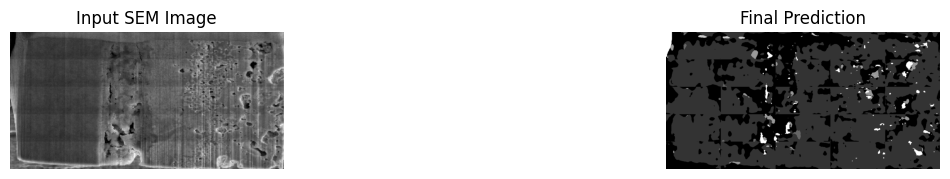

In [41]:
# save predictions images
# cv2.imwrite(f"{fig_directory}{slicex}.png",msk) # save prediction
plt.figure(figsize=(12, 8)); 
plt.subplot(231);plt.imshow(img,cmap="gray");plt.axis(False);plt.title("Input SEM Image")
# plt.subplot(232);plt.imshow(gt,cmap="gray");plt.axis(False);plt.title("Ground Truth ")
plt.subplot(233);plt.imshow(msk,cmap="gray");plt.axis(False);plt.title("Final Prediction")

In [42]:
import numpy as np

def reconstruct_image(patches, original_shape):
    """
    Reconstruct the original image from patches.

    Args:
        patches (numpy array): Array of image patches of shape (num_patches, patch_height, patch_width).
        original_shape (tuple): Shape of the original image (height, width).

    Returns:
        numpy array: Reconstructed image of shape `original_shape`.
    """
    # Get the number of patches along each dimension
    patch_height, patch_width = patches.shape[1], patches.shape[2]
    original_height, original_width = original_shape

    # Calculate the number of patches needed along each dimension
    num_patches_y = original_height // patch_height
    print(num_patches_y)
    num_patches_x = original_width // patch_width

    # Initialize an empty array for the reconstructed image
    reconstructed_image = np.zeros(original_shape, dtype=patches.dtype)

    # Reconstruct the image by placing patches in their correct positions
    patch_idx = 0
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            y_start = y * patch_height
            y_end = y_start + patch_height
            x_start = x * patch_width
            x_end = x_start + patch_width
            reconstructed_image[y_start:y_end, x_start:x_end] = patches[patch_idx]
            patch_idx += 1

    return reconstructed_image


In [29]:
# Example dimensions
original_shape = (640,1280)
patches = X_test[:,:,:,0]  # Replace with your patches

# Reconstruct the original image
reconstructed_image = reconstruct_image(patches, original_shape)

# Verify the shape
print(reconstructed_image.shape)  # Should print (1280, 640)

5
(640, 1280)


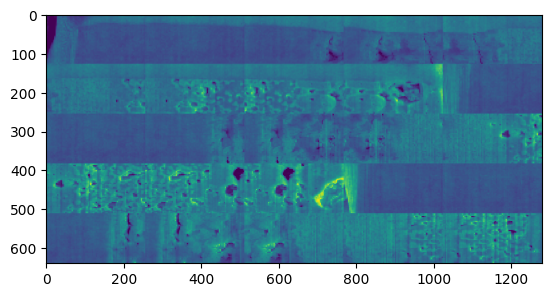

In [21]:
plt.imshow(reconstructed_image)